# speechbrain calculate DER using pyannote metric
#### AMI - mixHeadset DER 25%

In [1]:
# !pip install https://github.com/pyannote/pyannote-audio/archive/develop.zip
# !pip install torch==1.11.0 torchaudio==0.11.0 torchvision==0.12.0

# !pip install speechbrain

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2/3"
# CUDA_VISIBLE_DEVICES options = 0/1/2/3. Make sure to restart
!echo $CUDA_VISIBLE_DEVICES

2/3


In [32]:
import os
import wget
import logging
import pickle
import json
import glob
import shutil
import librosa
import numpy as np

import matplotlib.pyplot as plt
import IPython
from omegaconf import OmegaConf
import speechbrain as sb
from tqdm.contrib import tqdm
from hyperpyyaml import load_hyperpyyaml
import sklearn 

from speechbrain.utils.distributed import run_on_main
from speechbrain.processing.PLDA_LDA import StatObject_SB
from speechbrain.processing import diarization as diar
from speechbrain.utils.DER import DER
from speechbrain.dataio.dataio import read_audio, read_audio_multichannel

from pyannote.database.util import load_rttm
from pyannote.metrics.diarization import DiarizationErrorRate

import warnings
warnings.filterwarnings(action='once')


In [3]:
# set root and data dir all files

ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'data')
os.makedirs(data_dir, exist_ok=True)
print("Data dir: ", data_dir)

# DEMO_FILE = {'uri': 'ES2004a.Mix-Headset', 'audio': 'ES2004a.Mix-Headset.wav'}
audio_uri = 'aepyx'
audio_filename = 'aepyx.wav'
rttm_filename = 'aepyx.rttm' #  loads a dictionary
audio_path = os.path.join(data_dir, audio_filename)
rttm_path = os.path.join(data_dir, rttm_filename)

if not os.path.exists(audio_path):
    audio_path = wget.download('http://groups.inf.ed.ac.uk/ami/AMICorpusMirror/amicorpus/ES2004a/audio/ES2004a.Mix-Headset.wav'
                              , data_dir)
if not os.path.exists(rttm_path):
    # manual annotations (a.k.a groundtruth) in rttm file
    rttm_path = wget.download('https://raw.githubusercontent.com/pyannote/pyannote-audio/master/tutorials/data_preparation/AMI/MixHeadset.test.rttm'
                              , data_dir)
audio_path

Data dir:  /home/DATA/amit_kesari/SD1/speechbrain_try/data


'/home/DATA/amit_kesari/SD1/speechbrain_try/data/aepyx.wav'

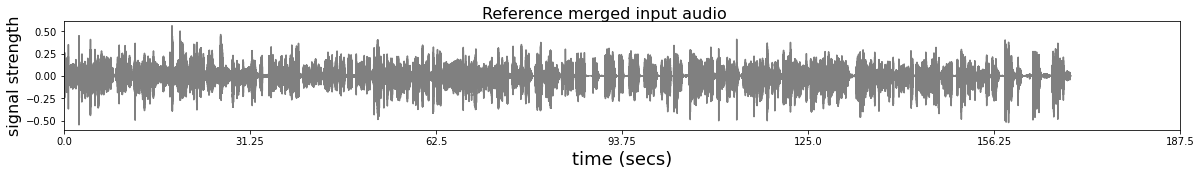

In [6]:
# plot audio
sr = 16000
signal, sr = librosa.load(audio_path,sr=sr) 

# plot and listen to the audio and visualize the RTTM speaker labels
fig,ax = plt.subplots(1,1)
fig.set_figwidth(20)
fig.set_figheight(2)
plt.plot(np.arange(len(signal)),signal,'gray')
fig.suptitle('Reference merged input audio', fontsize=16)
plt.xlabel('time (secs)', fontsize=18)
ax.margins(x=0)
plt.ylabel('signal strength', fontsize=16)
a,_ = plt.xticks()
plt.xticks(a,a/sr)
plt.show()



In [7]:
# TAKES A LOT OF TIME. RUN ONLY FOR VISUALISATION

# IPython.display.Audio(ami_audio)


In [4]:
# load the yaml config file for ecapa-tdnn
MODEL_CONFIG = os.path.join(data_dir,'hparams/ecapa_tdnn.yaml')
hp_dir = os.path.join(data_dir,'hparams')
os.makedirs(hp_dir, exist_ok=True)
if not os.path.exists(MODEL_CONFIG):
    config_url = "https://raw.githubusercontent.com/speechbrain/speechbrain/develop/recipes/AMI/Diarization/hparams/ecapa_tdnn.yaml"
    MODEL_CONFIG = wget.download(config_url, hp_dir)

# config = OmegaConf.load(MODEL_CONFIG)
# print(OmegaConf.to_yaml(config))

MODEL_CONFIG

'/home/DATA/amit_kesari/SD1/speechbrain_try/data/hparams/ecapa_tdnn.yaml'

In [5]:
# set config directives overrides
# config.data_folder = data_dir
# config.manual_annot_folder = data_dir

In [6]:
# """This recipe implements diarization system using deep embedding extraction followed by spectral clustering.

# To run this recipe:
# > python experiment.py hparams/<your_hyperparams_file.yaml>
#  e.g., python experiment.py hparams/ecapa_tdnn.yaml

# Condition: Oracle VAD (speech regions taken from the groundtruth).

# Note: There are multiple ways to write this recipe. We iterate over individual recordings.
#  This approach is less GPU memory demanding and also makes code easy to understand.

# Citation: This recipe is based on the following paper,
#  N. Dawalatabad, M. Ravanelli, F. Grondin, J. Thienpondt, B. Desplanques, H. Na,
#  "ECAPA-TDNN Embeddings for Speaker Diarization," arXiv:2104.01466, 2021.

# """

# np.random.seed(1234)

# # Logger setup
# logger = logging.getLogger(__name__)
# current_dir = ROOT
# logger

In [7]:
# get receipe for speechbrain SD
EXPERIMENT_FILE = os.path.join(data_dir,'experiment.py')
AMI_PREPARE_FILE = os.path.join(data_dir, 'ami_prepare.py')
AMI_SPLITS_FILE = os.path.join(data_dir, 'ami_splits.py')
if not os.path.exists(EXPERIMENT_FILE):
    experiment_uri = "https://raw.githubusercontent.com/speechbrain/speechbrain/develop/recipes/AMI/Diarization/experiment.py"
    ami_prepare_url = "https://raw.githubusercontent.com/speechbrain/speechbrain/develop/recipes/AMI/ami_prepare.py"
    ami_splits_uri = 'https://raw.githubusercontent.com/speechbrain/speechbrain/develop/recipes/AMI/ami_splits.py'
    EXPERIMENT_FILE = wget.download(experiment_uri, data_dir)
    AMI_PREPARE_FILE = wget.download(ami_prepare_url, data_dir)
    AMI_SPLITS_FILE = wget.download(ami_splits_uri, data_dir)

!cat {MODEL_CONFIG}

# ##################################################
# Model: Speaker Diarization Baseline
# Embeddings: Deep embedding
# Clustering Technique: Spectral clustering
# Authors: Nauman Dawalatabad 2020
# #################################################

seed: 1234
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# Directories: Replace !PLACEHOLDER with full path of the directory.
# Download data from: http://groups.inf.ed.ac.uk/ami/download/
data_folder: !PLACEHOLDER # e.g., /path/to/amicorpus/

# Download manual annotations from: http://groups.inf.ed.ac.uk/ami/download/
manual_annot_folder: !PLACEHOLDER # e.g., /path/to/ami_public_manual_1.6.2/

output_folder: results/ami/ecapa/
save_folder: !ref <output_folder>/save
device: 'cuda:0'

# Embedding model
# Here, the pretrained embedding model trained with train_speaker_embeddings.py hparams/train_ecapa_tdnn.yaml
# is downloaded from the speechbrain HuggingFace repository.
# However, a local path pointing to a directory containing your 

In [10]:
audio_data_folder = '/home/DATA/amit_kesari/AMI-diarization-setup/pyannote/amicorpus/'
manual_annot_folder = os.path.join(data_dir, 'ami_public_manual_1.6.2')
batch_size = 128
!python {EXPERIMENT_FILE} {MODEL_CONFIG} --data_folder={audio_data_folder} --manual_annot_folder={manual_annot_folder} --batch_size={batch_size}

/root/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/ami/ecapa/
speechbrain.pretrained.fetching - Fetch embedding_model.ckpt: Using existing file/symlink in results/ami/ecapa/save/embedding_model.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained files for: embedding_model
__main__ - Tuning for p-value for SC (Multiple iterations over AMI Dev set)
__main__ - Diarizing dev set
100%|██████████████████████████████████████████| 14/14 [28:03<00:00, 120.28s/it]
__main__ - Diarizing dev set
100%|███████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s]
__main__ - Diarizing dev set
100%|███████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s]
__main__ - Diari

In [33]:
# TODO metric using pyannote

# all rttms in one file
out_dir = os.path.join(ROOT, 'results/ami/ecapa')
groundtruth_rttm_filepath = os.path.join(out_dir, 'save/ref_rttms/fullref_ami_eval.rttm')
groundtruth_rttm_filepath2 = os.path.join(out_dir, 'save/ref_rttms/fullref_ami_eval2.rttm')
hypothesis_rttm_filepath = os.path.join(out_dir, 'save/sys_rttms/Mix-Headset/AMI_eval/oracle_cos_SC/sys_output.rttm')

!grep -i "SPEAKER" {groundtruth_rttm_filepath} > {groundtruth_rttm_filepath2}
print(groundtruth_rttm_filepath2)

if not os.path.exists(groundtruth_rttm_filepath):
    print("Please give correct rttm groundtruth location. No ", groundtruth_rttm_filepath)

test_type = 'test'

# rttm_dir = Path(rttm_dir)
# out_dir = Path(out_dir)

# forgiveness collar be default is 0
ami_test_labels = ['EN2002a','EN2002b','EN2002c','EN2002d','ES2004a','ES2004b','ES2004c','ES2004d','IS1009a','IS1009b','IS1009c','IS1009d']
metric = DiarizationErrorRate(collar=0.00, skip_overlap=False)
for label in ami_test_labels:
    ref = load_rttm(groundtruth_rttm_filepath2)
    ref = ref[label]
    hyp = load_rttm(hypothesis_rttm_filepath)
    hyp = hyp[label]
    _ = metric(ref, hyp)

df = metric.report(display=True)

# saving the dataframe to csv
df.to_csv(out_dir+'/speechbrain_ami_der26.csv')
df

# pred_labels = rttm_to_labels(data_dir+'/pred_rttms/'+ami_label+'.rttm')
# hypothesis = labels_to_pyannote_object(pred_labels)
# der = metric(groundtruth, hypothesis)
# print(f"Diarization error rate (DER) = {100 * der:.1f}%\n\n")


/home/DATA/amit_kesari/SD1/speechbrain_try/results/ami/ecapa/save/ref_rttms/fullref_ami_eval2.rttm


/root/anaconda3/lib/python3.9/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/root/anaconda3/lib/python3.9/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/root/anaconda3/lib/python3.9/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/root/anaconda3/lib/python3.9/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/root/anaconda3/lib/python3.9/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
/root/anaconda3/lib/python3.9/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'u

        diarization error rate    total  correct correct false alarm false alarm missed detection missed detection confusion confusion
                             %                         %                       %                                 %                   %
item                                                                                                                                  
EN2002a                  36.69  2910.97  1842.97   63.31        0.00        0.00           965.90            33.18    102.10      3.51
EN2002b                  33.78  2173.78  1439.46   66.22        0.00        0.00           654.04            30.09     80.27      3.69
EN2002c                  30.90  3551.64  2454.08   69.10        0.00        0.00           902.12            25.40    195.43      5.50
EN2002d                  37.87  3042.98  1890.49   62.13        0.00        0.00          1065.94            35.03     86.55      2.84
ES2004a                  25.01  1051.71   788.64   74.9

diarization error rate      total    correct            false alarm  \
                             %                                %               
item                                                                          
EN2002a              36.688904   2910.970   1842.967  63.311096         0.0   
EN2002b              33.780634   2173.778   1439.462  66.219366         0.0   
EN2002c              30.902736   3551.637   2454.084  69.097264         0.0   
EN2002d              37.873671   3042.982   1890.493  62.126329         0.0   
ES2004a              25.013240   1051.707    788.641  74.986760         0.0   
ES2004b              16.961221   2403.801   1996.087  83.038779         0.0   
ES2004c              17.826891   2439.528   2004.636  82.173109         0.0   
ES2004d              24.858799   2258.484   1697.052  75.141201         0.0   
IS1009a              23.002619    771.773    594.245  76.997381         0.0   
IS1009b              15.489123   2074.643   1753.299  84.510877         0.0   
IS1009c              11.428376   1680.335   1488.300  88.571624         0.0   
IS1009d              18.881409   1891.665   1534.492  81.118591         0.0   
TOTAL                25.779844  26251.303  19483.758  74.220156         0.0   

             missed detection            confusion            
           %                           %                   %  
item                                                          
EN2002a  0.0          965.898  33.181311   102.105  3.507594  
EN2002b  0.0          654.045  30.087939    80.271  3.692695  
EN2002c  0.0          902.125  25.400259   195.428  5.502477  
EN2002d  0.0         1065.942  35.029520    86.547  2.844151  
ES2004a  0.0          223.892  21.288439    39.174  3.724802  
ES2004b  0.0          334.355  13.909429    73.359  3.051792  
ES2004c  0.0          377.031  15.455080    57.861  2.371811  
ES2004d  0.0          453.481  20.079000   107.951  4.779799  
IS1009a  0.0          143.162  18.549755    34.366  4.452864  
IS1009b  0.0          277.791  13.389822    43.553  2.099301  
IS1009c  0.0          144.791   8.616794    47.244  2.811582  
IS1009d  0.0          293.861  15.534516    63.312  3.346893  
TOTAL    0.0         5836.374  22.232702   931.171  3.547142

'IS1009d'

## visualize embeddings

In [57]:
# retrieve emebdiing in speechbrain_try/results/ami/ecapa/save/emb/AMI_dev/ES2011a.Mix-Headset.emb_stat.pkl
import pickle as pkl

print("label:", label)
with open(out_dir+"/save/emb/AMI_eval/"+label+".Mix-Headset.emb_stat.pkl",'rb') as pickl:
    embed=pickle.load(pickl)
    print(embed)
    
embed = embed.stat1
hyp = load_rttm(hypothesis_rttm_filepath)
hyp = hyp[label]


label: IS1009d
------------------------------
modelset: array(['IS1009d_39.135_42.125', 'IS1009d_40.635_43.625',
       'IS1009d_42.135_45.125', ..., 'IS1009d_1919.82_1922.144',
       'IS1009d_1922.88_1923.248', 'IS1009d_1925.088_1926.094'],
      dtype=object)
segset: array(['IS1009d_39.135_42.125', 'IS1009d_40.635_43.625',
       'IS1009d_42.135_45.125', ..., 'IS1009d_1919.82_1922.144',
       'IS1009d_1922.88_1923.248', 'IS1009d_1925.088_1926.094'],
      dtype=object)
seg start:array([None, None, None, ..., None, None, None], dtype=object)
seg stop:array([None, None, None, ..., None, None, None], dtype=object)
stat0:array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])
stat1:array([[-15.93123436,  31.5349884 ,   8.39898682, ..., -18.31821251,
        -12.32909012, -13.52765274],
       [-28.97217941,   1.81385803, -41.41917038, ...,  -0.0711689 ,
        -17.84723663,   7.58633947],
       [-15.56447411,  18.63442612, -25.01073837, ..., -41.851

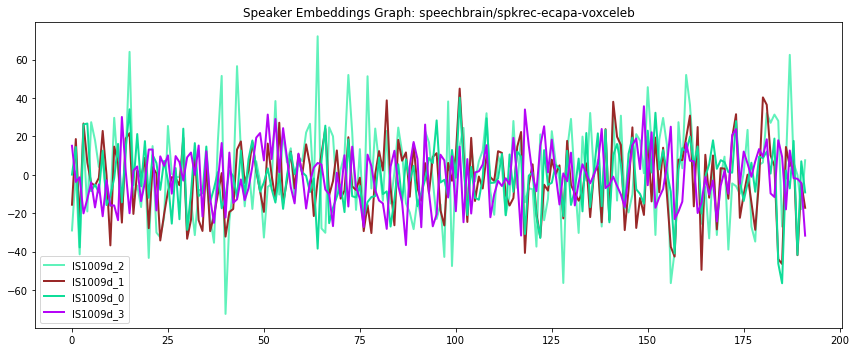

Saved embedding files to /home/DATA/amit_kesari/SD1/speechbrain_try/results/ami/ecapa/IS1009d_embeddings.pkl


In [56]:
def get_speakers_embedding(annotation, label, embed, plot=True, embed_model="speechbrain/spkrec-ecapa-voxceleb"):
    """
    get single segments for each speaker, and return their embeddings
    `embedding` is (1 x D) numpy array extracted from the file excerpt.
    
    embed_model = ["speechbrain/spkrec-ecapa-voxceleb", "pyannote/embedding"]

    """
    speaker_segments = {}
    speaker_embeds = {}

    index = 0
    for turn, _, speaker in annotation.itertracks(yield_label=True):
        index += 1
        # print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker={speaker}")
        if not speaker in speaker_segments.keys():
            speaker_segments[speaker] = index

    
    for speaker, turn in speaker_segments.items():
        # extract embedding for a speaker speaking between turns
        speaker_embeds[speaker] = embed[speaker_segments[speaker]] 
        
        
    # Speaker spk00 embed shape:(192,)
    # print("ss",speaker_segments)
    # print("se", speaker_embeds)
    if plot == True:
        plt.rcParams["figure.figsize"] = [12, 5]
        plt.rcParams["figure.autolayout"] = True
        plt.rcParams['lines.linewidth'] = 2
        
        np.random.seed(42)
        x = np.arange(0,len(speaker_embeds[speaker]))
        plt.title(f"Speaker Embeddings Graph: {embed_model}")

        
        for speaker, embed in speaker_embeds.items():
            plt.plot(x, embed, color=np.random.rand(3,))
        plt.legend(speaker_embeds.keys())
        plt.show()
            
    
    return speaker_embeds   

        
speaker_embeds = get_speakers_embedding(annotation = hyp,label=label, embed=embed, plot=True)



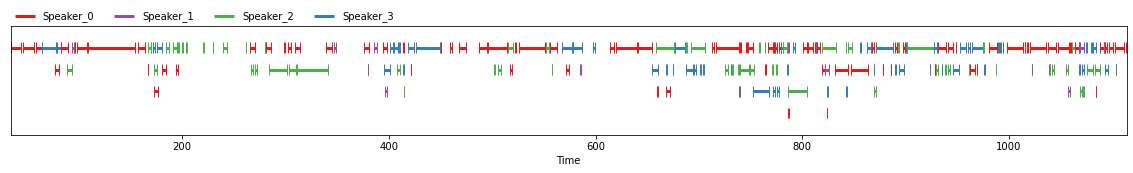

In [11]:
# load groundtruth

DEMO_FILE = {'uri': 'ES2011a', 'audio': 'ES2011a.Array1-01.wav'}
GROUNDTRUTH_FILE = "ES2011a-groundtruth.rttm"
HYPOTHESIS_FILE = "ES2011a-hypothesis.rttm"

groundtruth = load_rttm(GROUNDTRUTH_FILE)
groundtruth = groundtruth['meeting'] # get groundtruth of DEMO

# visualize groundtruth
groundtruth
# This nice visualization is by pyannote.core and basically indicates when each speaker speaks.
# SPEAKER {file_name} 1 {start_time} {duration} <NA> <NA> {speaker_name} <NA> <NA>

In [12]:
# from pyannote.core import Segment, notebook
# # make notebook visualization zoom on 600s < t < 660s time range
# EXCERPT = Segment(600, 660)
# notebook.crop = EXCERPT

# # visualize excerpt groundtruth
# groundtruth

# from pyannote.audio.features import RawAudio
# from IPython.display import Audio

# load audio waveform, crop excerpt, and play it
# waveform = RawAudio(sample_rate=16000).crop(DEMO_FILE, EXCERPT)
# Audio(data=waveform.squeeze(), rate=16000, autoplay=True)

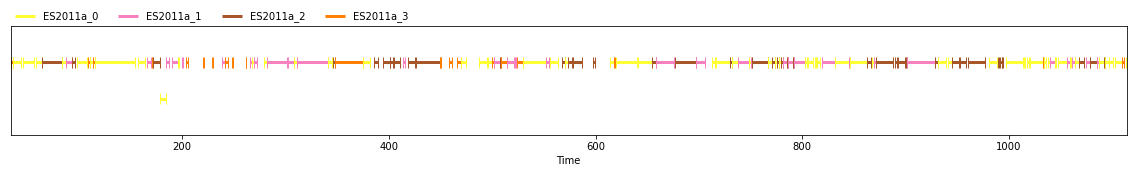

In [13]:
# load hypothesis

hypothesis = load_rttm(HYPOTHESIS_FILE) # this is generated by speechbrain
hypothesis = hypothesis[DEMO_FILE['uri']] 

# visualize groundtruth
hypothesis



In [14]:
# DER by finding optimal one-to-one mapping between groundtruth and hypothesized speakers.
metric = DiarizationErrorRate()
der = metric(groundtruth, hypothesis)
print(f'diarization error rate  = {100 * der:.1f}%')

diarization error rate  = 28.3%


/root/anaconda3/lib/python3.9/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


In [7]:
# changing the speaker labels
label_mapping = metric.optimal_mapping(groundtruth, hypothesis)
hypothesis = hypothesis.rename_labels(mapping=label_mapping)


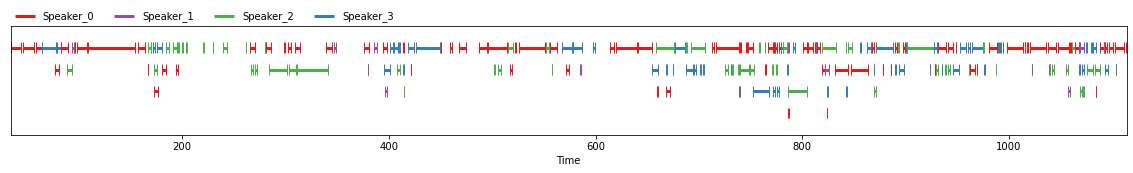

In [8]:
groundtruth

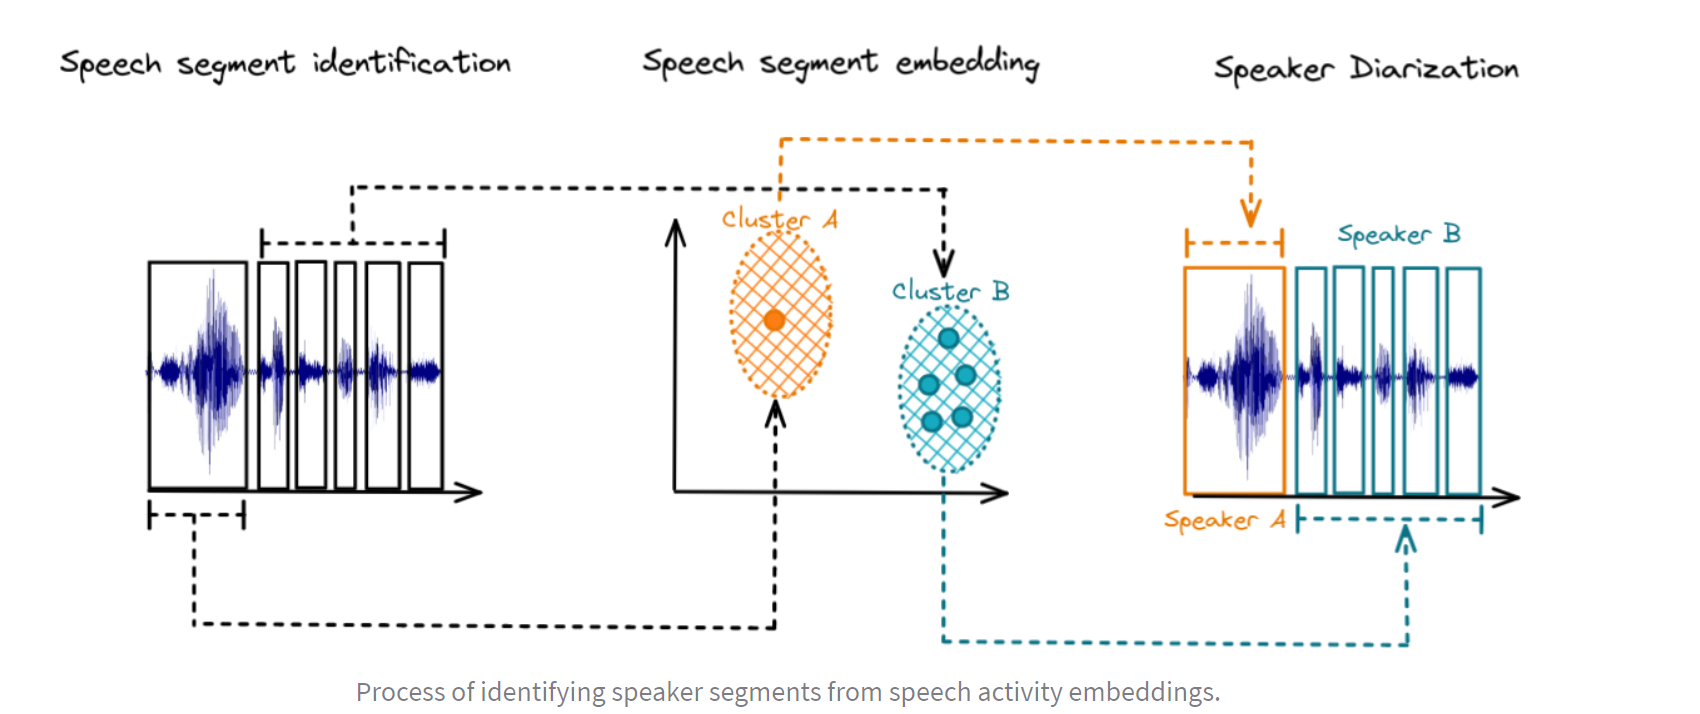


In [11]:
# speaker verification
from speechbrain.pretrained import SpeakerRecognition
verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="pretrained_models/spkrec-ecapa-voxceleb")
score, prediction = verification.verify_files("speechbrain/spkrec-ecapa-voxceleb/example1.wav", "speechbrain/spkrec-ecapa-voxceleb/example2.flac")
score, prediction


Downloading:   0%|          | 0.00/104k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

(tensor([0.1635]), tensor([False]))

In [ ]:
# # not importing
# from pyannote.audio.pipelines import SpeakerDiarization
# CONFIG = {
#     "segmentation": "pyannote/segmentation",
#     "embedding": "speechbrain/spkrec-ecapa-voxceleb",
#     "clustering": "AgglomerativeClustering"
# }
# PARAMS = {
#     "onset": 0.5, "offset": 0.5,
#     "stitch_threshold": 0.04, "min_activity": 6.0,
#     "clustering": {"method": "average", "threshold": 0.595}
# }

# pipeline = SpeakerDiarization(**CONFIG).instantiate(PARAMS)
# dia_pipeline = pipeline(DEMO_FILE['audio'])